#Stock Price Prediction using LSTM with Live yfinance Data

In [14]:
!pip install yfinance pandas numpy matplotlib scikit-learn tensorflow

# Importing Libraries

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os

# Data Collection

In [16]:
# Set up yfinance data extraction
def fetch_and_explore_data(ticker_symbol, start_date, end_date, output_path='data/stock_data.csv'):
    """
    Fetches historical stock data using yfinance and performs basic exploration.

    Args:
        ticker_symbol (str): The stock ticker symbol (e.g., 'AAPL', 'MSFT').
        start_date (str): Start date for data retrieval (YYYY-MM-DD).
        end_date (str): End date for data retrieval (YYYY-MM-DD).
        output_path (str): Path to save the fetched data CSV.
    """
    print(f"Fetching data for {ticker_symbol} from {start_date} to {end_date}...")
    try:
# Fetching historical data
        stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

        if stock_data.empty:
            print(f"No data found for {ticker_symbol} in the specified date range. Please check the ticker symbol and dates.")
            return None

        print("\nData fetched successfully!")
# Basic data exploration
        print("\n--- Basic Data Exploration ---")


        print("\nHead of the data:")
        print(stock_data.head())

        print("\nInfo of the data:")
        stock_data.info()

        print("\nDescriptive statistics:")
        print(stock_data.describe())

        print("\nMissing values per column:")
        print(stock_data.isnull().sum())

        stock_data.to_csv(output_path)
        print(f"\nData saved to {output_path}")

        return stock_data

    except Exception as e:
        print(f"An error occurred during data fetching or exploration: {e}")
        return None


# Data Preprocessing

In [17]:
def preprocess_data(df, target_column='Close', sequence_length=60, train_split_ratio=0.7, val_split_ratio=0.15):
    """
    Handles missing values, performs feature engineering,scaling data,
    creates time series sequences, and trains,validates and splits data.

    Args:
        df (pd.DataFrame): The input DataFrame containing stock data.
        target_column (str): The column to predict (e.g., 'Close').
        sequence_length (int): The number of past days to use for prediction.
        train_split_ratio (float): Ratio of data to use for training.
        val_split_ratio (float): Ratio of data to use for validation.

    Returns:
        tuple: A tuple containing:
            - X_train, y_train (np.array): Training features and labels.
            - X_val, y_val (np.array): Validation features and labels.
            - X_test, y_test (np.array): Test features and labels.
            - scaler (MinMaxScaler): The fitted scaler object.
            - target_col_index (int): Index of the target column within the scaled features.
            - features (list): List of feature names used.
    """
    print("\n--- Starting Data Preprocessing ---")

#Handle missing values
    initial_missing = df.isnull().sum().sum()
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    if df.isnull().sum().sum() > 0:
        print(f"Warning: Still missing values after ffill/bfill. Consider more advanced imputation.")
        df.dropna(inplace=True)
    print(f"Missing values handled. Initial NaNs: {initial_missing}, Remaining NaNs: {df.isnull().sum().sum()}")


#Feature engineering
    df['SMA_10'] = df['Close'].rolling(window=10).mean() # Creates a new column 'SMA_10' which is the 10-day Simple Moving Average of the 'Close' price.
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean() #Creates 'EMA_10' which is the 10-day Exponential Moving Average.
    df['Daily_Return'] = df['Close'].pct_change() #Calculates the daily percentage change in 'Close' price.

    df.dropna(inplace=True)
    print(f"Features engineered. DataFrame shape after feature engineering: {df.shape}")

    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_20', 'EMA_10', 'Daily_Return']
    data = df[features].values


#Scalling Data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    print("Data scaled using MinMaxScaler.")

    target_col_index = features.index(target_column)

#Create time series sequences
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i, :])
        y.append(scaled_data[i, target_col_index])

    X, y = np.array(X), np.array(y)
    print(f"Created {len(X)} sequences. X shape: {X.shape}, y shape: {y.shape}")

#Train/validation/test split
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(
        X, y, test_size=(1 - train_split_ratio), shuffle=False
    )

    val_test_ratio = val_split_ratio / (1 - train_split_ratio)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_temp, y_train_temp, test_size=val_test_ratio, shuffle=False
    )

    print(f"Data split into training, validation, and test sets.")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    return X_train, y_train, X_val, y_val, X_test, y_test, scaler, target_col_index, features

# Model Development

In [18]:
#Design LSTM architecture
def build_lstm_model(input_shape, lstm_units=50, dropout_rate=0.2, learning_rate=0.001):
    """
    Builds and compiles an LSTM neural network model.

    Args:
        input_shape (tuple): The shape of the input data (sequence_length, num_features).
        lstm_units (int): Number of LSTM units in the first layer.
        dropout_rate (float): Dropout rate for regularization.
        learning_rate (float): Learning rate for the Adam optimizer.

    Returns:
        tensorflow.keras.Model: The compiled LSTM model.
    """
    print("\n--- Building LSTM Model ---")
#Implement training pipeline
    model = Sequential([
        LSTM(units=lstm_units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),

        LSTM(units=lstm_units, return_sequences=False),
        Dropout(dropout_rate),

        Dense(units=1)
    ])
#Add regularization
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    print("\nLSTM Model Summary:")
    model.summary()
    print("\nModel built and compiled successfully.")

    return model

# Training & Evaluation

In [19]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test,
                             scaler, target_col_index, features,
                             epochs=50, batch_size=32, model_save_path='models/lstm_stock_predictor.h5',
                             results_dir='results'):
    """
    Trains the LSTM model, evaluates its performance, generates predictions,
    and creates visualizations.

    Args:
        model (tensorflow.keras.Model): The compiled LSTM model.
        X_train, y_train (np.array): Training features and labels.
        X_val, y_val (np.array): Validation features and labels.
        X_test, y_test (np.array): Test features and labels.
        scaler (MinMaxScaler): The fitted scaler object used for preprocessing.
        target_col_index (int): Index of the target column in the scaled features.
        features (list): List of feature names used during scaling.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        model_save_path (str): Path to save the trained model.
        results_dir (str): Directory to save plots and evaluation results.
    """
    print("\n--- Starting Model Training ---")

# Create directories if they don't exist
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)

# Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1
    )
    print("\nModel training complete.")

    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")

    print("\n--- Evaluating Model Performance ---")

#Evaluate performance
    predictions_scaled = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
    dummy_predictions_array = np.zeros((len(predictions_scaled), len(features)))
    dummy_predictions_array[:, target_col_index] = predictions_scaled.flatten()
    predictions = scaler.inverse_transform(dummy_predictions_array)[:, target_col_index]

    dummy_actual_array = np.zeros((len(y_test), len(features)))
    dummy_actual_array[:, target_col_index] = y_test.flatten()
    actual_prices = scaler.inverse_transform(dummy_actual_array)[:, target_col_index]

    min_len = min(len(predictions), len(actual_prices))
    predictions = predictions[:min_len]
    actual_prices = actual_prices[:min_len]

#Key Metrics
    rmse = np.sqrt(mean_squared_error(actual_prices, predictions))
    mae = mean_absolute_error(actual_prices, predictions)
    mape = np.mean(np.abs((actual_prices - predictions) / actual_prices)) * 100
    mape = mape if not np.isinf(mape) else 0

#Directional accuracy
    actual_direction = np.sign(np.diff(actual_prices))
    predicted_direction = np.sign(np.diff(predictions))
    min_len_direction = min(len(actual_direction), len(predicted_direction))
    actual_direction = actual_direction[:min_len_direction]
    predicted_direction = predicted_direction[:min_len_direction]

    correct_directions = np.sum(actual_direction == predicted_direction)
    directional_accuracy = (correct_directions / len(actual_direction)) * 100 if len(actual_direction) > 0 else 0

    print(f"\nKey Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Directional Accuracy: {directional_accuracy:.2f}%")

    with open(os.path.join(results_dir, 'evaluation_metrics.txt'), 'w') as f:
        f.write(f"RMSE: {rmse:.4f}\n")
        f.write(f"MAE: {mae:.4f}\n")
        f.write(f"MAPE: {mape:.2f}%\n")
        f.write(f"Directional Accuracy: {directional_accuracy:.2f}%\n")
    print(f"Key metrics saved to {os.path.join(results_dir, 'evaluation_metrics.txt')}")

    print("\n--- Generating Visualizations ---")

#Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(results_dir, 'model_loss.png'))
    plt.show()
    print(f"Loss plot saved to {os.path.join(results_dir, 'model_loss.png')}")

#Visualization of predictions vs actual
    plt.figure(figsize=(15, 7))
    plt.plot(actual_prices, label='Actual Prices', color='blue')
    plt.plot(predictions, label='Predicted Prices', color='red', linestyle='--')
    plt.title('Stock Price Prediction (Actual vs. Predicted)')
    plt.xlabel('Time (Days in Test Set)')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(results_dir, 'predictions_vs_actual.png'))
    plt.show()
    print(f"Predictions vs. Actual plot saved to {os.path.join(results_dir, 'predictions_vs_actual.png')}")

    print("\nTraining, evaluation, and visualization complete.")


# Deliverables

Directories 'data', 'models', 'results' created.
Fetching data for AAPL from 2006-01-01 to 2024-01-01...


/tmp/ipython-input-16-168242089.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Data fetched successfully!

--- Basic Data Exploration ---

Head of the data:
Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2006-01-03  2.246551  2.246551  2.171415  2.175322  807234400
2006-01-04  2.253162  2.283517  2.239036  2.257971  619603600
2006-01-05  2.235431  2.251058  2.216497  2.248955  449422400
2006-01-06  2.293133  2.305155  2.240539  2.261577  704457600
2006-01-09  2.285621  2.320184  2.276304  2.306058  675040800

Info of the data:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4529 entries, 2006-01-03 to 2023-12-29
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   4529 non-null   float64
 1   (High, AAPL)    4529 non-null   float64
 2   (Low, AAPL)     4529 non-null   float64
 3   (Open, AAPL)    4529 non-null   float64
 4   (Volume


/tmp/ipython-input-17-1050377724.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-17-1050377724.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,251 (125.98 KB)

 Trainable params: 32,251 (125.98 KB)

 Non-trainable params: 0 (0.00 B)


Model built and compiled successfully.

--- Starting Model Training ---
Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 0.0010 - mae: 0.0235 - val_loss: 1.1724e-04 - val_mae: 0.0091
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 1.3832e-04 - mae: 0.0092 - val_loss: 1.2682e-04 - val_mae: 0.0082
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 7.6175e-05 - mae: 0.0067 - val_loss: 9.9821e-05 - val_mae: 0.0074
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 5.6469e-05 - mae: 0.0058 - val_loss: 3.5185e-05 - val_mae: 0.0045
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 4.5116e-05 - mae: 0.0052 - val_loss: 1.2949e-04 - val_mae: 0.0093
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.9778e-05 - mae: 0.0050 - val_loss: 5.0616e-05 - val_mae: 0.0051
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 3.5848e-05 - mae: 0.0046 - val_loss: 3.4188e-05 - val_mae: 0.0044
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - l


Model training complete.
Model saved to models/lstm_stock_predictor.h5

--- Evaluating Model Performance ---
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

Key Metrics:
RMSE: 21.1787
MAE: 16.1439
MAPE: 11.29%
Directional Accuracy: 52.28%
Key metrics saved to results/evaluation_metrics.txt

--- Generating Visualizations ---


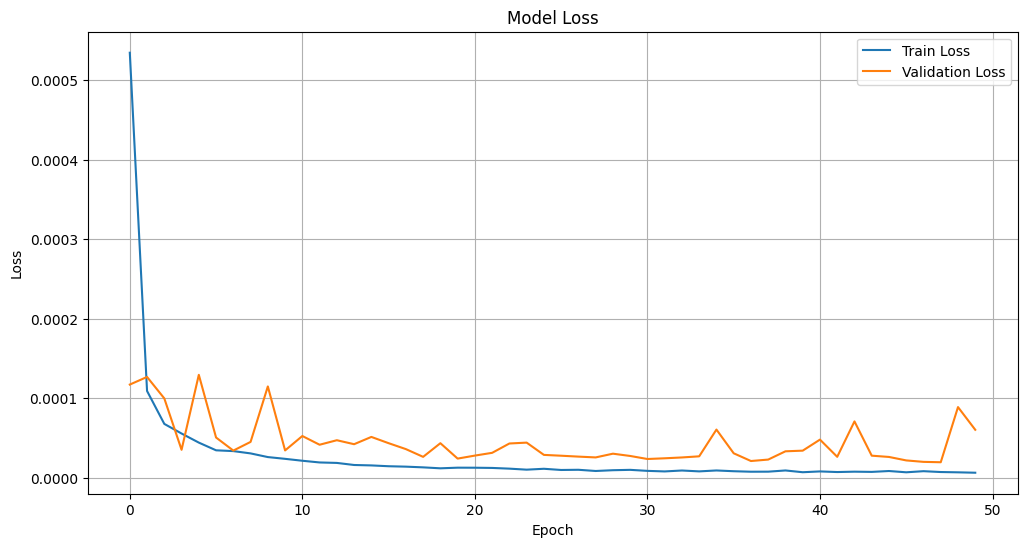

Loss plot saved to results/model_loss.png


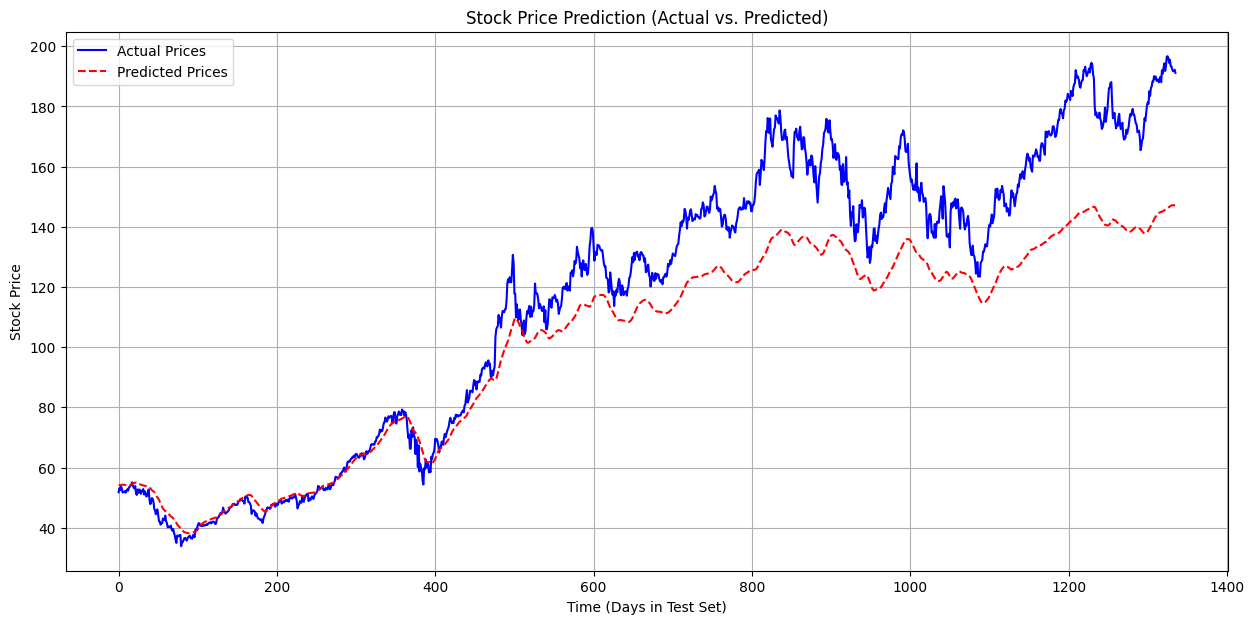

Predictions vs. Actual plot saved to results/predictions_vs_actual.png

Training, evaluation, and visualization complete.

--- Project Execution Complete ---
Trained model saved to: models/lstm_stock_predictor.h5
Evaluation metrics and plots saved to: results


In [20]:
if __name__ == "__main__":
# Define parameters
    ticker = 'AAPL'
    start_date = '2006-01-01'
    end_date = '2024-01-01'
    data_file_path = 'data/AAPL_historical_data.csv'
    sequence_length = 60
    train_split_ratio = 0.7
    val_split_ratio = 0.15
    target_column = 'Close'
    epochs = 50
    batch_size = 32
    model_save_path = 'models/lstm_stock_predictor.h5'
    results_dir = 'results'

#Necessary directories
    os.makedirs('data', exist_ok=True)
    os.makedirs('models', exist_ok=True)
    os.makedirs('results', exist_ok=True)
    print("Directories 'data', 'models', 'results' created.")

#Data collection script
    df = fetch_and_explore_data(ticker, start_date, end_date, data_file_path)

    if df is None:
        print("Exiting: Data collection failed.")
    else:
      X_train, y_train, X_val, y_val, X_test, y_test, scaler, target_col_index, features = preprocess_data(
            df,
            target_column=target_column,
            sequence_length=sequence_length,
            train_split_ratio=train_split_ratio,
            val_split_ratio=val_split_ratio
        )

#LSTM model implementation
      input_shape = (X_train.shape[1], X_train.shape[2])
      model = build_lstm_model(input_shape, lstm_units=50, dropout_rate=0.2, learning_rate=0.001)

#Training pipeline
      train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test,
                               scaler, target_col_index, features,
                               epochs=epochs,batch_size=batch_size,model_save_path=model_save_path,results_dir=results_dir
        )

#Evaluation results and Prediction visualizations
      print("\n--- Project Execution Complete ---")
      print(f"Trained model saved to: {model_save_path}")
      print(f"Evaluation metrics and plots saved to: {results_dir}")

